# **5장. 합성곱 신경망 1**

**5.1.2 합성곱 신경망 구조**

: **입력층**에서 입력받은 데이터가 **합성곱층**과 **풀링층**을 거치면서 입력 이미지의 주요 특성 벡터가 추출되고, 추출된 주요 특성 벡터들은 **완전연결층**을 거치며 1차원 벡터로 변환되며, **출력층**에서 활성화함수인 소프트멕스 함수를 사용하여 최종 결과가 출력됨

**5.1.3 1D, 2D, 3D 합성곱**

1. 1D 합성곱 : 1차원 입력 + 1차원 필터(좌우 움직임) = 1차원 출력

2. 2D 합성곱 : 2차원 입력(W,H) + 2차원 필터(k,k) = 2차원 출력

3. 3D 합성곱 : 3차원 입력(W, H, L) + 3차원 필터(k,k,d) = 3차원 출력 (d<L)

4. 3D 입력을 갖는 2D 합성곱 : 3차원 입력(W, H, L) + 3차원 필터(k, k, L) = 2차원 출력(d=L)

5. 1x1 합성곱 : 3차원 입력(W, H, L) + 3차원 필터(1, 1, L) = 2차원 출력(W, H)



In [1]:
#라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
#CPU or GPU 장치 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/pytorch_ex/chap05', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/pytorch_ex/chap05', download=True, train=False,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
#fashionMNIST를 다운받을 위치 / <-위치에 해당 데이터셋이 있는지 확인 후 내려받음 / 이미지를 텐서(0~1)로 변경

In [11]:
#데이터를 데이터로더에 전달(내려받은 데이터를 메모리로 불러오기 위해)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100) #100개 단위로 데이터를 배치로 묶어서 불러옴
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [15]:
print(len(train_dataset))
print(train_dataset[0][1]) #tensor(n차원 특성 가진 텐서, 레이블 숫자)

60000
9


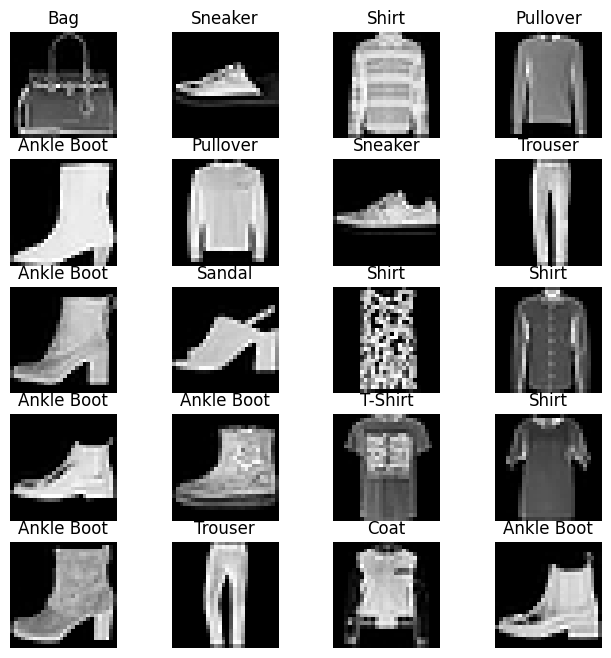

In [19]:
#분류에 사용될 클래스 정의
labels_map = {   0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'   }

fig = plt.figure(figsize=(8,8)) ; #출력할 이미지의 가로세로 크기(단위: 인치)
columns = 4 ; #그림 4열 출력
rows = 5 ; #그림 5행 출력
for i in range(1, columns*rows + 1) : #열*행만큼의 그림
  img_xy = np.random.randint( len(train_dataset) ) ; #랜덤 샘플 1개 인덱스
  img = train_dataset[img_xy][0][0,:,:] #??
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() #20개의 이미지 데이터를 시각적으로 표현

In [28]:
#심층 신경망 모델 생성

class FashionDNN(nn.Module) :
  def __init__(self) :
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256) #1차 은닉층 구현
    self.drop = nn.Dropout(0.25) #드롭아웃 구현(과적합 막음)
    self.fc2 = nn.Linear(in_features=256, out_features=128) #2차 은닉층 구현
    self.fc3 = nn.Linear(in_features=128, out_features=10) #출력층 구현

  def foward(self, input_data) :
    out = input_data.view(-1, 784) #텐서 모양 재구성 -> self.fc1에 들어갈 수 있게 (파이토치의 .view는 넘파이의 .reshape와 같은 역할)
    out = F.relu( self.fc1(out) )
    out = self.drop( out )
    out = F.relu( self.fc2(out) ) #F.relu(): foward() 함수에서 사용 / nn.ReLU(): __init__() 함수에서 정의
    out = self.fc3( out )
    return out

In [29]:
#심층 신경망에 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss() #크로스 엔트로피(다중 분류 손실함수)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [30]:
#심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = [] #손실 누적
iteration_list = [] #반복 누적
accuracy_list = [] #정확도 누적

predictions_list = [] #예측값 누적
labels_list = []


for epoch in range(num_epochs) :
  for images, labels in train_loader :
    images, labels = images.to(device), labels.to(device)

    train = Variable( images.view(100, 1, 28, 28) )
    labels = Variable(labels)

    outputs = model(train) #훈련 세트를 모델에 적용
    loss = criterion(outputs, labels) #손실함수(크로스 엔트로피)
    optimizer.zero_grad() #가중치 0으로 초기화
    loss.backward() #역전파
    optimizer.step()
    count += 1

    if not (count % 50) : #count를 50으로 나눈 나머지가 0이 아니라면
      total = 0
      correct = 0
      for images, labels in test_loader : #테스트 세트
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable( images.view(100, 1, 28, 28) )
        outputs = model(test) #테스트 세트를 신경망에 넣어 출력
        predictions = torch.max(outputs, 1)[1].to(device) #테스트 세트의 예측값
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total

      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500) :
      print(f'Iteration: {count}, Accuracy: {accuracy}, Loss: {loss.data}')

NotImplementedError: Module [FashionDNN] is missing the required "forward" function